Задание 1. A/B–тестирование
1.1 Условие
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. 
Для этого мы применяем метод A/B–тестирования. 
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 
В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.
1.2 Входные данные
В качестве входных данных Вы имеете 4 csv-файла:
groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 
1.3 Вопросы
Предлагаем Вам ответить на следующие вопросы:
На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.
1.4 Требования к ответу
При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

# Python и EDA

In [1]:
# Импортируем библиотеки
import requests
import urllib
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandahouse as ph

import scipy.stats as ss
# from scipy.stats import bootstrap

%matplotlib inline

In [2]:
# Подгружаем данные
df_active_students = pd.read_csv('active_studs.csv', encoding='UTF-8')
df_checks = pd.read_csv('checks.csv', encoding='UTF-8',sep=';')
df_group_add = pd.read_csv('group_add.csv', encoding='UTF-8')
df_groups = pd.read_csv('groups.csv', encoding='UTF-8',sep=';')

In [3]:
df_active_students.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [4]:
print(f"Размерность active_students {df_active_students.shape}")
print(f"Уникальных {df_active_students.student_id.nunique()}")
# Все студенты уникальны
print(f"Количество пустых:\n{df_active_students.isnull().sum()}") # Необязательно

Размерность active_students (8341, 1)
Уникальных 8341
Количество пустых:
student_id    0
dtype: int64


In [5]:
df_checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [6]:
print(f"Размерность df_checks {df_checks.shape}")
print(f"Уникальных {df_checks.student_id.nunique()}")
# Все студенты уникальны с присвоенным rev
print(f"Количество пустых:\n{df_checks.isnull().sum()}") # Необязательно

Размерность df_checks (541, 2)
Уникальных 541
Количество пустых:
student_id    0
rev           0
dtype: int64


In [7]:
df_group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [8]:
print(f"Размерность df_group_add {df_group_add.shape}")
print(f"Размерность df_group_add {df_group_add.id.nunique()}")
print(f"Количество групп: df_group_add {df_group_add.grp.nunique()}")
# Дополнительные пользователи с группой, уникальны 
print(f"Количество пустых:\n{df_group_add.isnull().sum()}")

Размерность df_group_add (92, 2)
Размерность df_group_add 92
Количество групп: df_group_add 2
Количество пустых:
id     0
grp    0
dtype: int64


In [9]:
df_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [10]:
print(f"Размерность df_groups {df_groups.shape}")
print(f"Уникальных df_groups {df_groups.id.nunique()}")
print(f"Количество групп: df_group_add {df_groups.grp.nunique()}")
# Пользователи и их группы, уникальны
print(f"Количество пустых:\n{df_groups.isnull().sum()}")

Размерность df_groups (74484, 2)
Уникальных df_groups 74484
Количество групп: df_group_add 2
Количество пустых:
id     0
grp    0
dtype: int64


Посмотрим все ли участники испытания попали в группы. Также возникает вопрос. что делать со студентами, которые присоединились после эксперимента. Мы сравним со студентами, которые не попали в группы.

In [11]:
# подправим название столбцов в df_group_add и df_groups
df_group_add = df_group_add.rename(columns={'id':'student_id'})
df_groups = df_groups.rename(columns={'id':'student_id'})

In [12]:
# Студенты из актива, которые не попали в группы
df_students_without_groups = df_active_students.merge(df_groups, on='student_id', how='left')\
.query('grp.isnull()')

In [13]:
# Сравним с дополнительной группой
df_students_without_groups_bag = df_students_without_groups.merge(df_group_add, on='student_id',how='inner')
df_students_without_groups_bag.head()

,student_id,grp_x,grp_y
0,5723133,NaN,A
1,5951797,NaN,B
2,5730382,NaN,B
3,5739944,NaN,B
4,5945085,NaN,B


In [14]:
# Подправим таблицу
df_students_without_groups_bag = df_students_without_groups_bag.drop(columns='grp_x').rename(columns={'grp_y':'grp'})

У нас есть 13 студентов, которые есть в активной группе, но им не досталось группы в подборе групп, но есть в дополнительной группе участников. Будем считать, что они ошибочно не попали в распределение групп. Они участники эксперимента добавим их и составим одну общую активную таблицу с участниками и их группами.

In [15]:
df_students_active = df_active_students.merge(df_groups, on='student_id', how='inner')\
.merge(df_students_without_groups_bag, on=['student_id','grp'], how='outer')
df_students_active.shape
# Все участники эксперимента получили свою группу

(8341, 2)

Теперь посмотрим, что с чеками

In [16]:
df_students_active_with_checks = df_students_active.merge(df_checks,on='student_id',how='left')

In [17]:
df_students_active_with_checks.query('rev.isnull() == False').shape
# 392 чека попали в активную группу
# Сделаем отдельный датафрейм и посмотрим на ср чек сумму у активной группы
df_active_checks = df_students_active_with_checks.query('rev.isnull() == False')

In [18]:
# Посмотрим на разные основные метрики чека среди всех активных пользователей среди купивших
print(f"Средний чек:{df_active_checks['rev'].mean()}")
print(f"Мода чека:{df_active_checks['rev'].mode()}")
print(f"Медиана чека:{df_active_checks['rev'].median()}")
print(f"Сумма чеков:{df_active_checks['rev'].sum()}")

Средний чек:1193.3520497448978
Мода чека:0    1900.0
dtype: float64
Медиана чека:990.0
Сумма чеков:467794.0035


Мода на 1900, значит большое количество пользователей потратили ровно 1900, что-то из новой механики оплаты?

In [19]:
# Заполним пустые значения и перейдем с готовым датафреймом к тестам
# Все проверим
df_students_active_with_checks = df_students_active_with_checks.fillna(0)
df_students_active_with_checks.head()

,student_id,grp,rev
0,581585,A,0.0
1,3276743,B,0.0
2,4238589,A,0.0
3,4475369,B,0.0
4,5481015,B,0.0


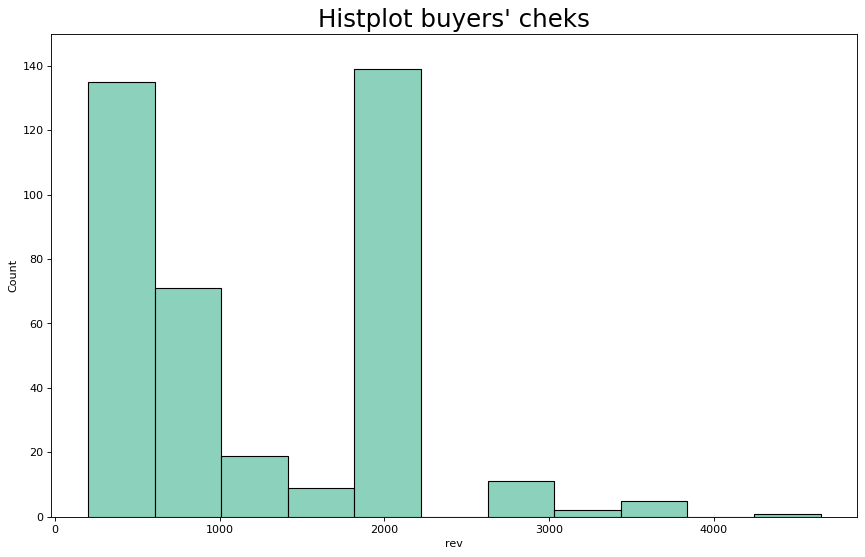

In [20]:
# Распределение чека среди тех кто платил
plt.figure(figsize=(13,8), dpi= 80)
sns.set_palette(sns.color_palette('Set2', 2))
sns.histplot(df_students_active_with_checks.query('rev != 0.0'), x='rev', kde=False)
plt.ylim(0, 150)

plt.title('Histplot buyers\' cheks', fontsize=22)
plt.show()

In [21]:
df_students_active_with_checks.dtypes

student_id      int64
grp            object
rev           float64
dtype: object

In [22]:
df_students_active_with_checks.isnull().sum()

student_id    0
grp           0
rev           0
dtype: int64

In [23]:
#Проверим сколько чеков не попало в активную группу
df_checks['rev'].count() - df_students_active_with_checks.query('rev!= 0.0')['rev'].count()

149

Эти 149 платежей сочтем за автоматические, они точно были не от интересующей нас группы

In [24]:
# Наш рабочий датафрейм для тестов
df_students_active_with_checks.head()

,student_id,grp,rev
0,581585,A,0.0
1,3276743,B,0.0
2,4238589,A,0.0
3,4475369,B,0.0
4,5481015,B,0.0


# 1.Перейдем к A/B тестам 

Остановимся на метриках:
 - ARPU - средний доходность с одного пользователя
 - CR - Конверсия в покупку, посмотрим на привлекательность нововведений
 - ARPPU или AOV в нашем случае разницы нет, у нас 1 пользователь = 1 покупка, метрики буду равны
 
Для указаных метрик достаточно данных, и они наиболее точно отразят зависимость групп от изменения механики оплаты. Все оплаты являются уникальными, нет повторных. Ключевыми метриками будут CR(посмотрим как повлияла новая система оплаты с точки зрения привлекательности) и ARPPU(так как мы исследуем изменения в оплате, которые затронут группы покупающих). Для начала посчитаем каждую метрику для каждой группы.

In [25]:
# Посчитаем сколько всего пользователей в группе и общий доход каждой группы
df_metrics = df_students_active_with_checks.groupby('grp', as_index=False).agg({'rev':'sum', 'student_id':'count'}).round(0)
# Сколько человек совершили покупку
df_metrics['buyer_quantity'] = df_students_active_with_checks.query('rev != 0.0')\
.groupby('grp', as_index=False).agg({'student_id':'count'})['student_id']
# Посчитаем CR
df_metrics['CR'] = (df_metrics['buyer_quantity']/df_metrics['student_id']).round(3)
# Посчитаем ARPU и ARPPU
df_metrics['ARPU'] = (df_metrics['rev']/df_metrics['student_id']).round(2)
df_metrics['ARPPU_AOV'] = (df_metrics['rev']/df_metrics['buyer_quantity']).round(2)

In [26]:
df_metrics

,grp,rev,student_id,buyer_quantity,CR,ARPU,ARPPU_AOV
0,A,72820.0,1538,78,0.051,47.35,933.59
1,B,394974.0,6803,314,0.046,58.06,1257.88


Начнем с теcтирования CR в покупку
Исследуем CR:
- H0: При внедрении новой механики оплаты конверсия в покупку не изменится
- H1: при внедрении новой механики изменится конверсия в покупку

Для анализа будем использовать критерий независимости хи-квадрат — используется для определения наличия значимой связи между двумя категориальными переменными. Xи-квадрат подходит для использования при работе с категориальными переменными.

In [27]:
# Добавим данные о количестве некупивших для применения Xи-квадрат
df_metrics['no_buyers'] = df_metrics['student_id'] - df_metrics['buyer_quantity']
# тест хи-квадрат
chi2, pvalue, k, _ = ss.chi2_contingency(df_metrics[['no_buyers','buyer_quantity']].values)
critical = ss.chi2.ppf(0.95, k)
pvalue

0.48625240457231045

Значение p-value не позволяет нам отклонить нулеую гипотезу.

Исследуем чеки, посмотрим расспределение чеков. Также ARPU и ARPPU отличаются у данных групп. Посмотрим на график, и выберем метод тестирования

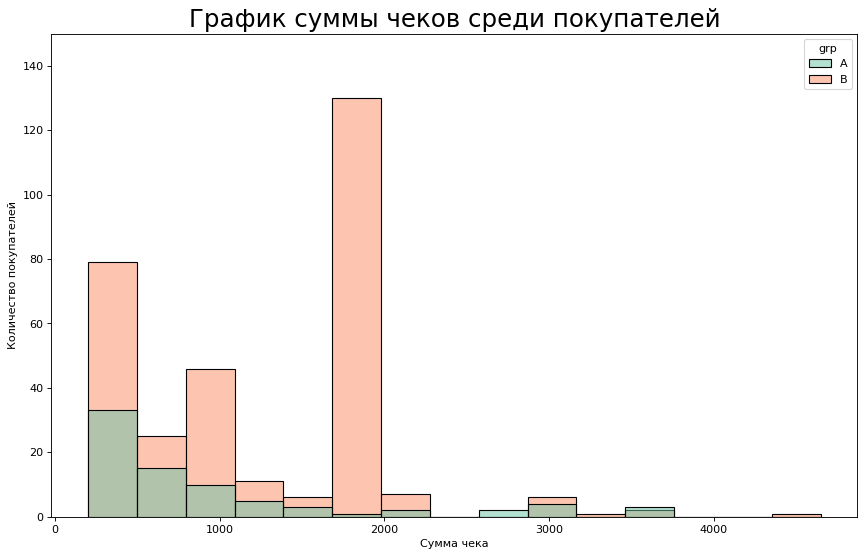

In [28]:
# Данные для график
date_hist = df_students_active_with_checks.query('rev != 0.0')
# Распределение чека среди тех кто платил по группам
plt.figure(figsize=(13,8), dpi= 80)
sns.set_palette(sns.color_palette('Set2', 2))
ax = sns.histplot(date_hist, x='rev', kde=False, bins=15, hue='grp', multiple='layer')
ax.set_xlabel('Сумма чека')
ax.set_ylabel('Количество покупателей')
plt.ylim(0, 150)

plt.title('График суммы чеков среди покупателей', fontsize=22)
plt.show()

Далее исследуем группы на ARPU_AOV. Данная метрика для нас наиболее актуальна, на графике мы видим существенные различия в данном показателе между группами. Также на графике мы видим, что распределение не нормальное. 

Можно логарифмировать наши данные, но это приведет к проблемам в понимании для бизнеса. И поэтому же не будем использовать непараметрический U-критерий Манна — Уитни.

Тогда посмотрим в сторону t-критерия Стьюдента. "На самом деле требование к нормальности есть, но не к данным, а к среднему. Среднее значение метрики должно иметь нормальное распределение" - из данного высказывания можем сделать вывод, что t-критерия Стьюдента можно использовать на данном распределении.

Размер наших выборок разный: 1538 и 6803. Как понял после прочтения большого количества источников, это не повлияет на результат как при ttest так и при bootstrap.

Сформулируем гипотезы:
- H0: Средний чек(ARPPU_AOV) не имеет значимых различий в контрольной группе и в целевой
- H1: Средний чек(ARPPU_AOV) имеет значимые различия

In [29]:
# Разобьем на группы
df_boots = df_students_active_with_checks.query('rev != 0.0')[['rev','grp']].reset_index(drop=True)
df_boots['rev'] = df_boots['rev'].round(2)
df_group_A = df_boots.query('grp=="A"')
df_group_B = df_boots.query('grp=="B"')

In [30]:
ruselt_ttest = ss.ttest_ind(df_group_A['rev'], df_group_B['rev'])
print(f'P-value = {ruselt_ttest.pvalue:0.4f}')

P-value = 0.0019


По проведенному тесту гипотезу H0 - отвергаем

Далее проведем бутстрап по данной же метрике, для повторной проверки

In [31]:
#Размер начальной выборки
raz_start = 1000 
#Количество подвыборок
raz_start_n = 10000
# уровень значимости
alpha = 0.05

#Разница квантилей
pe = np.quantile(df_group_B.rev, 0.95) - np.quantile(df_group_A.rev, 0.95)
# Бутстрап значений первой группы
bootstrap_values_a = np.random.choice(df_group_A.rev, (raz_start_n, raz_start), True)
# Бутстреп 
bootstrap_metrics_a = np.quantile(bootstrap_values_a, 0.95, axis=1)
# Бутстрап значений второй группы
bootstrap_values_b = np.random.choice(df_group_B.rev, (raz_start_n, raz_start), True)
bootstrap_metrics_b = np.quantile(bootstrap_values_b, 0.95, axis=1)
# Отражаем разницу интервалов между второй и первой группой
bootstrap_stats = bootstrap_metrics_b - bootstrap_metrics_a
# Строим перцентильный доверительный интервал
ci = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
# Проверяем значимость статистических данных, если в ноль не попадает то значения значимы
znach = not (ci[0] < 0 < ci[1])

print(f'Значение 95% квантиля изменилось на: {pe:0.2f}')
print(f'{((1 - alpha) * 100)}% доверительный интервал: ({ci[0]:0.2f}, {ci[1]:0.2f})')
print(f'Отличия статистически значимые: {znach}')

Значение 95% квантиля изменилось на: -930.00
95.0% доверительный интервал: (-1468.54, -796.45)
Отличия статистически значимые: True


Гипотеза H0: Средний чек(ARPPU_AOV) не имеет значимых различий в контрольной группе и в целевой - отвергается

На полученных данных мы видим, что у второй, тестовой группы, нижняя и верхние границы больше чем у контрольной группы. Отличия статистически значимы.

По A/B тестирование можно сделать следующие выводы:
    - Использованны метрики СR, ARPPU_AOV, ARPU(По данному пункту тесты не проводились, в его тестах не вижу необходимости)
    - CR не показал статистически значимых изменений между контрольной и тестовой группой
    - ARPPU показал статистически значимые изменения, в тестовой группе люди платили больше и делали это стабильнее.
Новою механику оплаты СТОИТ применять на всех пользователей. Она никак не повлияла на количество переходов в покупку, но повысила средний чек, сделав его стабильнее.

# 2.Задачи SQL

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".
Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

In [32]:
#Задаем найстройки сервера
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [41]:
quer = """
    SELECT 
        count(DISTINCT st_id) AS active_unique
    FROM (SELECT 
        st_id,
        subject,
        toMonth(timest) as month_,
        sum(correct) as ball
    FROM default.peas
    GROUP BY st_id, subject,month_
    HAVING ball>19 and month_= 10) as final"""

In [42]:
quer_default = ph.read_clickhouse(query=quer, connection = connection_default)
quer_default

,active_unique
0,78


Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

In [35]:
quer_second = """
    SELECT 
        s.test_grp,
        round(sum(money)/count(s.st_id),2) AS ARPU,
        round(count(CASE WHEN money !=0 THEN 1 END)/count(s.st_id),3) AS CR,
        round(sum(CASE WHEN ball != 0 THEN money END)/count(CASE WHEN ball != 0 THEN 1 END),2) AS ARPAU,
        round(count(CASE WHEN money !=0 and ball != 0 THEN 1 END)/count(CASE WHEN ball != 0 THEN 1 END),3) AS CR_b,
        round(count(CASE WHEN money !=0 and ball_math != 0 THEN 1 END)/count(CASE WHEN ball_math != 0 THEN 1 END),3) AS CR_math
    FROM default.studs as s
    LEFT JOIN default.final_project_check as fp
    ON s.st_id=fp.st_id
    LEFT JOIN 
            (
            SELECT DISTINCT active.st_id, sum(ball) AS ball
            FROM(
                SELECT st_id, subject, toMonth(timest) as month_,sum(correct) as ball
                FROM default.peas
                GROUP BY st_id, subject, month_
                HAVING ball>10 and month_=10
                ) as active
            GROUP BY active.st_id
            ) as active_students
    ON s.st_id = active_students.st_id
    LEFT JOIN
            (
            SELECT DISTINCT active_2.st_id, sum(ball) AS ball_math
            FROM
                (SELECT st_id, subject, toMonth(timest) as month_, sum(correct) as ball
                FROM default.peas
                GROUP BY st_id, subject, month_
                HAVING 
                    subject = 'Math'
                    and ball>=2
                    and month_=10
                ) as active_2
            GROUP BY active_2.st_id
            ) as active_math
    ON s.st_id = active_math.st_id
    GROUP BY test_grp"""

In [36]:
quer_default_second = ph.read_clickhouse(query=quer_second, connection = connection_default)
quer_default_second

,s.test_grp,ARPU,CR,ARPAU,CR_b,CR_math
0,control,4496.75,0.058,9708.33,0.125,0.120
1,pilot,11094.77,0.141,24484.54,0.299,0.217


# 3.Реализация функции на автоматическую выгрузку

1.Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [37]:
def give_metrics(public_key_first_df, public_key_second_df, public_key_third_df, public_key_fourth_df):
    """ Напишем функциию на автоматическую выгрузку метрик 
    На вход получаем ссылки на файлы
    Выводим метрики CR, ARPU, ARPPU, можем добавить и любые другие"""
    # Загрузим данные
    public_key_1 = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
    public_key_2 = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
    public_key_3 = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
    public_key_4 = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key_first_df))
    response_active = requests.get(final_url)
    download_url = response_active.json()['href']
    df_groups = pd.read_csv(download_url,sep=';')

    final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key_second_df))
    response_active = requests.get(final_url)
    download_url = response_active.json()['href']
    df_groups_add = pd.read_csv(download_url)

    final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key_third_df))
    response_active = requests.get(final_url)
    download_url = response_active.json()['href']
    df_active_studa = pd.read_csv(download_url)

    final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key_fourth_df))
    response_active = requests.get(final_url)
    download_url = response_active.json()['href']
    df_checks = pd.read_csv(download_url,sep=';')
    # Заголовки могут отличаться, исправим
    df_groups_add.rename(columns=({df_groups_add.columns[0]: 'student_id', df_groups_add.columns[1]: 'grp'}), inplace=True)
    df_groups = df_groups.rename(columns={'id':'student_id'})

    # Соединяем группы
    df_all_users_groups = pd.concat([df_groups_add,df_groups])
    # Проверим на пустые значения автоматически, удалим, если что
    if df_all_users_groups.grp.isnull().sum() != 0:
        df_all_users_groups = df_all_users_groups.dropna()

    # Все участники эксперимента получили свою группу
    df_students_active_with_groups = df_active_studa.merge(df_all_users_groups, on='student_id', how='inner')
    # Объедим с чеками
    df_students_active_with_checks = df_students_active_with_groups.merge(df_checks,on='student_id',how='left')
    # df_students_active_with_checks.query('rev.isnull() == False').shape
    # 392 чека попали в активную группу
    # Заполним пустые значения и перейдем с готовым датафреймом к метрикам
    df_students_active_with_checks = df_students_active_with_checks.fillna(0)
    # Посчитаем сколько всего пользователей в группе и общий доход каждой группы
    df_metrics = df_students_active_with_checks.groupby('grp', as_index=False).agg({'rev':'sum', 'student_id':'count'}).round(0)
    # Сколько человек совершили покупку
    df_metrics['buyer_quantity'] = df_students_active_with_checks.query('rev != 0.0')\
                                   .groupby('grp', as_index=False).agg({'student_id':'count'})['student_id']
    # Посчитаем CR
    df_metrics['CR'] = (df_metrics['buyer_quantity']/df_metrics['student_id']).round(3)
    # Посчитаем ARPU и ARPPU
    df_metrics['ARPU'] = (df_metrics['rev']/df_metrics['student_id']).round(2)
    df_metrics['ARPPU_AOV'] = (df_metrics['rev']/df_metrics['buyer_quantity']).round(2)
    # Сделаем наш отчет для каждого, а не только для нас
    df_metrics = df_metrics.rename(columns={'grp':'Группа',
                                            'rev':'Cумма чеков',
                                            'student_id':'Размер групп',
                                            'buyer_quantity':'Количество покупателей'})
    df_metrics.reset_index(inplace=False)
    return df_metrics

In [38]:
metrics = give_metrics('https://disk.yandex.ru/d/UhyYx41rTt3clQ',
                       'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ',
                       'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',
                       'https://disk.yandex.ru/d/pH1q-VqcxXjsVA')
metrics

,Группа,Cумма чеков,Размер групп,Количество покупателей,CR,ARPU,ARPPU_AOV
0,A,72820.0,1538,78,0.051,47.35,933.59
1,B,394974.0,6803,314,0.046,58.06,1257.88


2.Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [39]:
def get_visualisation(metrics):
    """Построим графики по полученным метрикам"""
    plt.figure(figsize=(23, 7))
    plt.suptitle('1 x 4 barplot for metrics')
    sns.set_palette(sns.color_palette('Set2', 2))
    plt.subplot(1, 4, 1)
    sns.barplot(x='Группа', y='Размер групп', data=metrics)
    plt.subplot(1, 4, 2)
    sns.barplot(x='Группа', y='CR', data=metrics)
    plt.subplot(1, 4, 3)
    sns.barplot(x='Группа', y='ARPU', data=metrics)
    plt.subplot(1, 4, 4)
    sns.barplot(x='Группа', y='ARPPU_AOV', data=metrics)

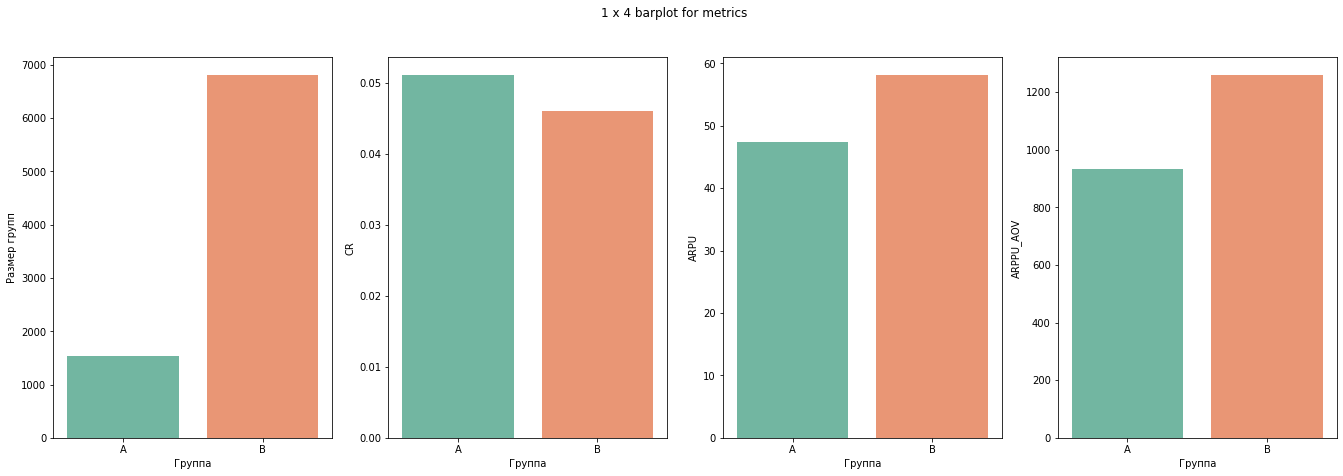

In [40]:
get_visualisation(metrics)